# 03 Time series

In this notebook we use traditional time series approaches.

## Reading data

We read the datasets from the csv files.

In [39]:
# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Time series packages
import catboost
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.metrics import mean_squared_error

sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dtype={
    'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32',
    'item_price': 'float32', 'item_cnt_day': 'int32'
})

test = pd.read_csv('data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

In [40]:
shop_ids = [2, 7]
item_ids = [4897, 7220]
sales = sales.query('shop_id == @shop_ids and item_id == @item_ids')

In [41]:
# We keep only shops and items present in the test dataset
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

sales = sales[sales['shop_id'].isin(test_shop_ids)]
sales = sales[sales['item_id'].isin(test_item_ids)]

In [42]:
# Aggregate data per month
monthly_sales = sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
monthly_sales = monthly_sales.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean','count']})

# And rename the columns
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [43]:
n_months = 34
date_block_nums = range(n_months)

shop_ids = monthly_sales['shop_id'].unique()

full_sales = []
for date_block_num in date_block_nums:
    for shop_id in shop_ids:
        shop_monthly_sales = monthly_sales[monthly_sales['shop_id'] == shop_id]

        item_ids = shop_monthly_sales['item_id'].unique()
        for item_id in item_ids:
            full_sales.append([date_block_num, shop_id, item_id])

full_sales = pd.DataFrame(full_sales, columns=['date_block_num', 'shop_id', 'item_id'])

full_sales.head().T
full_sales

,date_block_num,shop_id,item_id
0,0,2,7220
1,0,2,4897
2,0,7,7220
3,0,7,4897
4,1,2,7220
...,...,...,...
131,32,7,4897
132,33,2,7220
133,33,2,4897
134,33,7,7220


In [44]:
monthly_sales = pd.merge(full_sales, monthly_sales, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [45]:
monthly_sales.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
1,0,2,4897,0.0,0.0,0.0,0.0,0.0
5,1,2,4897,0.0,0.0,0.0,0.0,0.0
9,2,2,4897,0.0,0.0,0.0,0.0,0.0
13,3,2,4897,0.0,0.0,0.0,0.0,0.0
17,4,2,4897,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
118,29,7,7220,0.0,0.0,0.0,0.0,0.0
122,30,7,7220,0.0,0.0,0.0,0.0,0.0
126,31,7,7220,1299.0,1299.0,1.0,1.0,1.0
130,32,7,7220,0.0,0.0,0.0,0.0,0.0


In [19]:
monthly_sales['year'] = 2013 + monthly_sales['date_block_num'] // 12
monthly_sales['month'] = monthly_sales['date_block_num'] % 12

In [20]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

Text(0.5, 1.0, 'Montly sum')

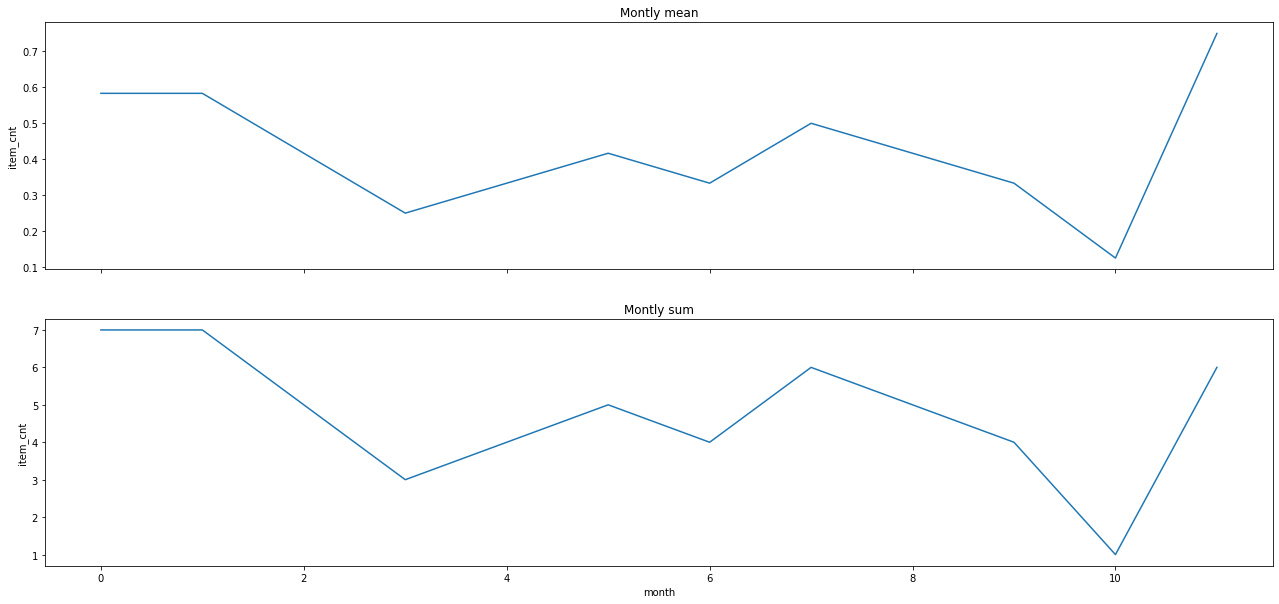

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axs[0]).set_title('Montly mean')
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axs[1]).set_title('Montly sum')

Text(0.5, 1.0, 'Montly sum')

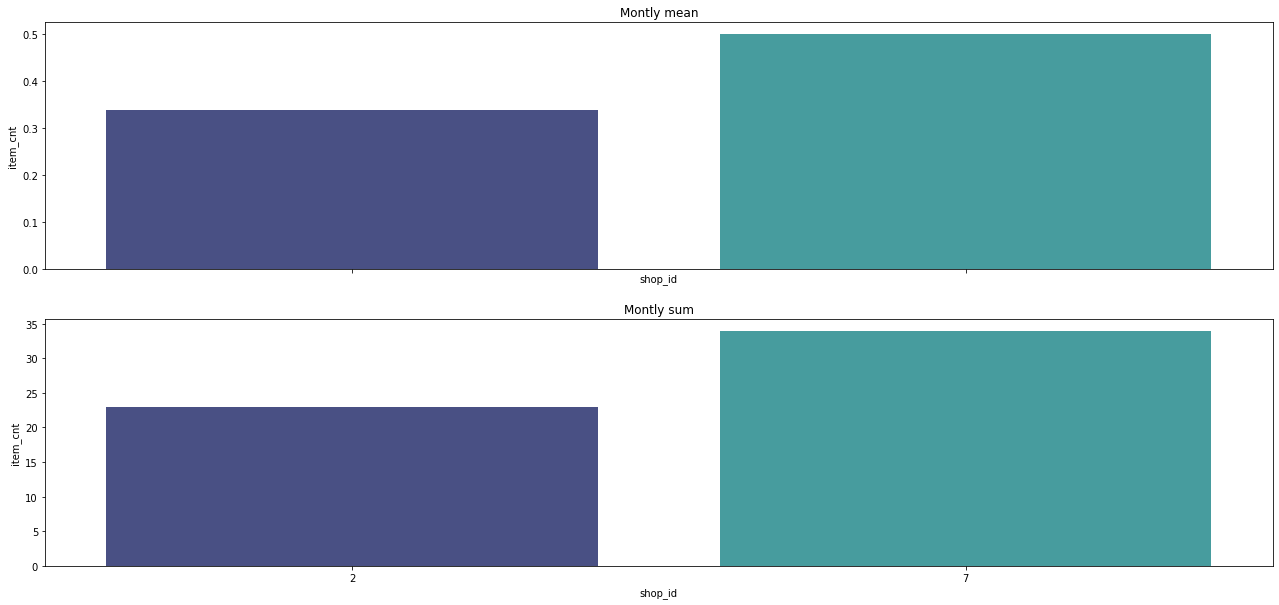

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axs[0], palette='mako').set_title('Montly mean')
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axs[1], palette='mako').set_title('Montly sum')

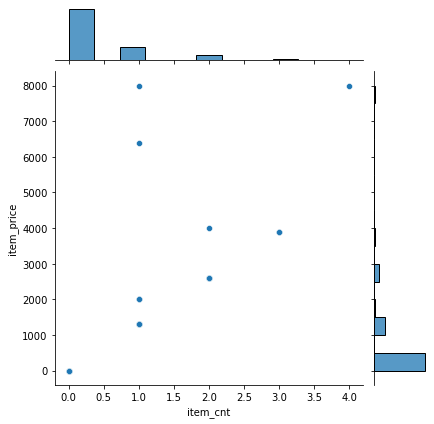

In [23]:
sns.jointplot(x='item_cnt', y='item_price', data=monthly_sales)

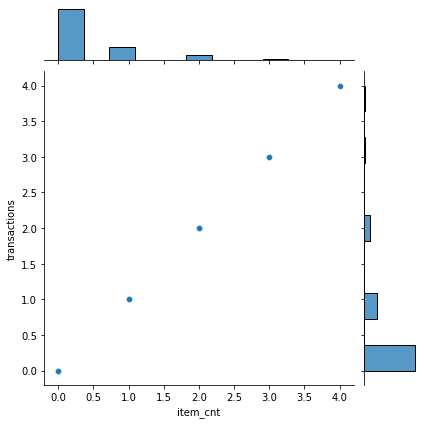

In [24]:
sns.jointplot(x='item_cnt', y='transactions', data=monthly_sales)

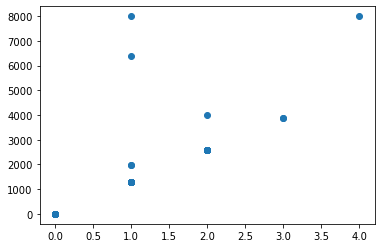

In [26]:
plt.scatter(x='item_cnt', y='item_price', data=monthly_sales)

In [27]:
# Remove outliers
monthly_sales = monthly_sales[monthly_sales['item_cnt'] >= 0]
monthly_sales = monthly_sales[monthly_sales['item_cnt'] <= 20]
monthly_sales = monthly_sales[monthly_sales['item_price'] <= 400000]

In [28]:
# Response variable
monthly_sales['item_cnt_next_month'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# Item price per unit
monthly_sales['item_price_unit'] = monthly_sales['item_price'] / monthly_sales['item_cnt']
monthly_sales['item_price_unit'] = monthly_sales['item_price_unit'].fillna(0).replace([np.inf, -np.inf], 0)

In [29]:
gp_item_price = monthly_sales.groupby(['item_id'], as_index=False).agg({'item_price': ['min', 'max']})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

In [30]:
monthly_sales = pd.merge(monthly_sales, gp_item_price, on=['item_id'], how='left')

# Price differences from historical min/max
monthly_sales['price_increase'] = monthly_sales['item_price'] - monthly_sales['hist_min_item_price']
monthly_sales['price_decrease'] = monthly_sales['hist_max_item_price'] - monthly_sales['item_price']

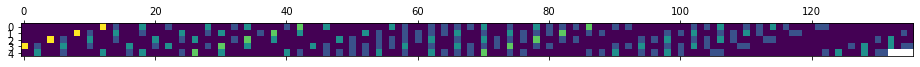

In [31]:
# Rolling window based features
window = 3

gp_monthly_sales = monthly_sales.groupby(['shop_id', 'item_id'])

# Actual value of last 3 months
for i in range(1, window + 1):
    monthly_sales['item_cnt_prev_month_' + str(i)] = gp_monthly_sales['item_cnt'].shift(i).fillna(0)

plt.matshow(monthly_sales[['item_cnt_prev_month_3', 'item_cnt_prev_month_2', 'item_cnt_prev_month_1', 'item_cnt', 'item_cnt_next_month']].T)

In [33]:
shifted = monthly_sales[[col for col in monthly_sales if col.startswith('item_cnt_prev_month')]]

# Min, max, mean and std of last 3 months
monthly_sales['item_cnt_prev_min'] = shifted.min(axis=1)
monthly_sales['item_cnt_prev_max'] = shifted.max(axis=1)
monthly_sales['item_cnt_prev_mean'] = shifted.mean(axis=1)
monthly_sales['item_cnt_prev_std'] = shifted.std(axis=1)

In [34]:
# Item trend with respect to last 3 months
monthly_sales['item_trend'] = monthly_sales['item_cnt'] - monthly_sales['item_cnt_prev_mean']

In [37]:
monthly_sales.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,price_increase,price_decrease,item_cnt_prev_month_1,item_cnt_prev_month_2,item_cnt_prev_month_3,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend
1,0,2,4897,0.0,0.0,0.0,0.0,0.0,2013,0,...,0.0,7999.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000
5,1,2,4897,0.0,0.0,0.0,0.0,0.0,2013,1,...,0.0,7999.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000
9,2,2,4897,0.0,0.0,0.0,0.0,0.0,2013,2,...,0.0,7999.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000
13,3,2,4897,0.0,0.0,0.0,0.0,0.0,2013,3,...,0.0,7999.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000
17,4,2,4897,0.0,0.0,0.0,0.0,0.0,2013,4,...,0.0,7999.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,29,7,7220,0.0,0.0,0.0,0.0,0.0,2015,5,...,0.0,7995.399902,0.0,1.0,0.0,0.0,1.0,0.333333,0.57735,-0.333333
122,30,7,7220,0.0,0.0,0.0,0.0,0.0,2015,6,...,0.0,7995.399902,0.0,0.0,1.0,0.0,1.0,0.333333,0.57735,-0.333333
126,31,7,7220,1299.0,1299.0,1.0,1.0,1.0,2015,7,...,1299.0,6696.399902,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1.000000
130,32,7,7220,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,7995.399902,1.0,0.0,0.0,0.0,1.0,0.333333,0.57735,-0.333333


In [40]:
# Train set: Months 3 to 27 (drop 0 to 2 as we use 3-month window)
train_set = monthly_sales[(monthly_sales['date_block_num'] >= 3) & (monthly_sales['date_block_num'] < 28)].dropna().copy()
# Validation set: Months 28 to 32
validation_set = monthly_sales[(monthly_sales['date_block_num'] >= 28) & (monthly_sales['date_block_num'] < 33)].dropna().copy()
# Test set: Month 33 (last with available data)
test_set = monthly_sales[monthly_sales['date_block_num'] == 33].copy()

train_set_perc = 100 * train_set.shape[0] / monthly_sales.shape[0]
validation_set_perc = 100 * validation_set.shape[0] / monthly_sales.shape[0]
test_set_perc = 100 * test_set.shape[0] / monthly_sales.shape[0]

train_set_perc, validation_set_perc, test_set_perc

(73.4975934336195, 14.710231301959956, 2.94295155182039)

In [41]:
train_set

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,price_increase,price_decrease,item_cnt_prev_month_1,item_cnt_prev_month_2,item_cnt_prev_month_3,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend
11709,3,31,32,3141.0,349.0,11.0,1.222222,9.0,2013,3,...,2992.0,2094.0,13.0,20.0,0.0,0.0,20.0,11.000000,10.148892,0.000000
11710,3,31,33,998.0,499.0,2.0,1.000000,2.0,2013,3,...,998.0,1996.0,3.0,6.0,5.0,3.0,6.0,4.666667,1.527525,-2.666667
11711,3,31,45,0.0,0.0,0.0,0.000000,0.0,2013,3,...,0.0,1196.0,0.0,2.0,1.0,0.0,2.0,1.000000,1.000000,-1.000000
11712,3,31,51,249.0,249.0,1.0,1.000000,1.0,2013,3,...,249.0,747.0,0.0,4.0,2.0,0.0,4.0,2.000000,2.000000,-1.000000
11713,3,31,53,0.0,0.0,0.0,0.000000,0.0,2013,3,...,0.0,1196.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109129,27,31,21948,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,1699.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
109130,27,31,21973,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,3598.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
109131,27,31,22004,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,1521.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
109132,27,31,22005,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,1859.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [42]:
validation_set

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,price_increase,price_decrease,item_cnt_prev_month_1,item_cnt_prev_month_2,item_cnt_prev_month_3,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend
109134,28,31,32,447.0,149.0,3.0,1.0,3.0,2015,4,...,298.0,4788.0,2.0,10.0,5.0,2.0,10.0,5.666667,4.041452,-2.666667
109135,28,31,33,199.0,199.0,1.0,1.0,1.0,2015,4,...,199.0,2795.0,1.0,2.0,2.0,1.0,2.0,1.666667,0.577350,-0.666667
109136,28,31,45,0.0,0.0,0.0,0.0,0.0,2015,4,...,0.0,1196.0,2.0,0.0,0.0,0.0,2.0,0.666667,1.154701,-0.666667
109137,28,31,51,0.0,0.0,0.0,0.0,0.0,2015,4,...,0.0,996.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
109138,28,31,53,299.0,299.0,1.0,1.0,1.0,2015,4,...,299.0,897.0,1.0,4.0,0.0,0.0,4.0,1.666667,2.081666,-0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128648,32,31,21948,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,1699.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
128649,32,31,21973,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,3598.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
128650,32,31,22004,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,1521.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
128651,32,31,22005,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,1859.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [43]:
test_set

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,price_increase,price_decrease,item_cnt_prev_month_1,item_cnt_prev_month_2,item_cnt_prev_month_3,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend
128653,33,31,32,447.0,149.0,3.0,1.000000,3.0,2015,9,...,298.0,4788.0,3.0,5.0,5.0,3.0,5.0,4.333333,1.154701,-1.333333
128654,33,31,33,398.0,199.0,2.0,1.000000,2.0,2015,9,...,398.0,2596.0,1.0,2.0,0.0,0.0,2.0,1.000000,1.000000,1.000000
128655,33,31,45,299.0,299.0,1.0,1.000000,1.0,2015,9,...,299.0,897.0,3.0,2.0,2.0,2.0,3.0,2.333333,0.577350,-1.333333
128656,33,31,51,0.0,0.0,0.0,0.000000,0.0,2015,9,...,0.0,996.0,1.0,0.0,0.0,0.0,1.0,0.333333,0.577350,-0.333333
128657,33,31,53,0.0,0.0,0.0,0.000000,0.0,2015,9,...,0.0,1196.0,3.0,2.0,2.0,2.0,3.0,2.333333,0.577350,-2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132549,33,31,21948,1699.0,1699.0,1.0,1.000000,1.0,2015,9,...,1699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
132550,33,31,21973,3598.0,1799.0,2.0,1.000000,2.0,2015,9,...,3598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.000000
132551,33,31,22004,1521.0,169.0,10.0,1.111111,9.0,2015,9,...,1521.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,10.000000
132552,33,31,22005,1859.0,169.0,12.0,1.090909,11.0,2015,9,...,1859.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,12.000000


In [53]:
# Shop mean encoding
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean = gp_shop_mean.reset_index()

# Item mean encoding
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_next_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean = gp_item_mean.reset_index()

# Shop-item mean encoding
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean = gp_shop_item_mean.reset_index()

# Year mean encoding
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_next_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean = gp_year_mean.reset_index()

# Month mean encoding
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_next_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean = gp_month_mean.reset_index()

# Add mean encodings to train and validation set
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [20]:
train_set

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,3,31,32,3141.0,349.0,11.0,1.222222,9.0,2013,3,...,13.0,24.0,19.000000,5.567764,-8.000000,1.252259,7.84,7.84,1.055272,0.998385
1,3,31,33,998.0,499.0,2.0,1.000000,2.0,2013,3,...,3.0,6.0,4.666667,1.527525,-2.666667,1.252259,1.28,1.28,1.055272,0.998385
2,3,31,45,0.0,0.0,0.0,0.000000,0.0,2013,3,...,0.0,2.0,1.000000,1.000000,-1.000000,1.252259,0.92,0.92,1.055272,0.998385
3,3,31,51,249.0,249.0,1.0,1.000000,1.0,2013,3,...,0.0,4.0,2.000000,2.000000,-1.000000,1.252259,0.84,0.84,1.055272,0.998385
4,3,31,53,0.0,0.0,0.0,0.000000,0.0,2013,3,...,1.0,1.0,1.000000,0.000000,-1.000000,1.252259,1.84,1.84,1.055272,0.998385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98045,27,31,21948,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,0.998385
98046,27,31,21973,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,0.998385
98047,27,31,22004,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,0.998385
98048,27,31,22005,0.0,0.0,0.0,0.000000,0.0,2015,3,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,0.998385


In [21]:
validation_set

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,28,31,32,447.0,149.0,3.0,1.0,3.0,2015,4,...,2.0,10.0,5.666667,4.041452,-2.666667,1.252259,7.84,7.84,1.359957,0.933580
1,28,31,33,199.0,199.0,1.0,1.0,1.0,2015,4,...,1.0,2.0,1.666667,0.577350,-0.666667,1.252259,1.28,1.28,1.359957,0.933580
2,28,31,45,0.0,0.0,0.0,0.0,0.0,2015,4,...,0.0,2.0,0.666667,1.154701,-0.666667,1.252259,0.92,0.92,1.359957,0.933580
3,28,31,51,0.0,0.0,0.0,0.0,0.0,2015,4,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.84,0.84,1.359957,0.933580
4,28,31,53,299.0,299.0,1.0,1.0,1.0,2015,4,...,0.0,4.0,1.666667,2.081666,-0.666667,1.252259,1.84,1.84,1.359957,0.933580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19605,32,31,21948,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,1.240056
19606,32,31,21973,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,1.240056
19607,32,31,22004,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,1.240056
19608,32,31,22005,0.0,0.0,0.0,0.0,0.0,2015,8,...,0.0,0.0,0.000000,0.000000,0.000000,1.252259,0.00,0.00,1.359957,1.240056


In [54]:
X_train = train_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_train = train_set['item_cnt_next_month'].astype(int)

X_validation = validation_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_validation = validation_set['item_cnt_next_month'].astype(int)

In [55]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [24]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((98050, 27), (98050,), (19610, 27), (19610,))

In [56]:
latest = validation_set[validation_set['date_block_num'] == 32]

X_test = pd.merge(test, latest, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

X_test['year'] = 2015
X_test['month'] = 9

X_test = X_test.drop('item_cnt_next_month', axis=1)

X_test[int_features] = X_test[int_features].astype('int32')

X_test = X_test[X_train.columns]

X_test.head().T
X_test

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,5037,749.5,749.5,1.0,1.0,1.0,2015,9,749.5,...,1.0,3.0,1.666667,1.154701,-0.666667,0.289650,0.737000,0.28,0.50441,0.417723
1,5,5320,NaN,NaN,NaN,NaN,NaN,2015,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,2997.0,999.0,3.0,1.0,3.0,2015,9,999.0,...,0.0,2.0,1.000000,1.000000,2.000000,0.289650,0.073171,0.12,0.50441,0.417723
3,5,5232,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.0,1.0,0.333333,0.577350,-0.333333,0.289650,0.000000,0.00,0.50441,0.417723
4,5,5268,NaN,NaN,NaN,NaN,NaN,2015,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.272274,0.458378,0.32,0.50441,0.417723
214196,45,16188,NaN,NaN,NaN,NaN,NaN,2015,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,45,15757,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.272274,0.261622,0.24,0.50441,0.417723
214198,45,19648,NaN,NaN,NaN,NaN,NaN,2015,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tree based models

### Catboost

In [57]:
# Specify indices for categorical features: shop_id, item_id, year and month
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation)
)

Learning rate set to 0.27
0:	learn: 4.2133959	test: 3.9294514	best: 3.9294514 (0)	total: 1.95s	remaining: 16m 10s
50:	learn: 2.3644782	test: 3.2825156	best: 3.2825156 (50)	total: 1m 5s	remaining: 9m 33s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 3.256369698
bestIteration = 61

Shrink model to first 62 iterations.


In [58]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


In [59]:
feature_scores = catboost_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features))
feature_scores = pd.DataFrame({'Feature': X_train.dtypes.index, 'Score': feature_scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

feature_scores

,Feature,Score
24,shop_item_mean,41.090438
4,item_cnt,27.915225
22,shop_mean,8.865807
21,item_trend,2.961307
26,month_mean,2.864855
7,year,1.872178
5,mean_item_cnt,1.723464
2,item_price,1.637692
0,shop_id,1.221511
19,item_cnt_prev_mean,1.144180


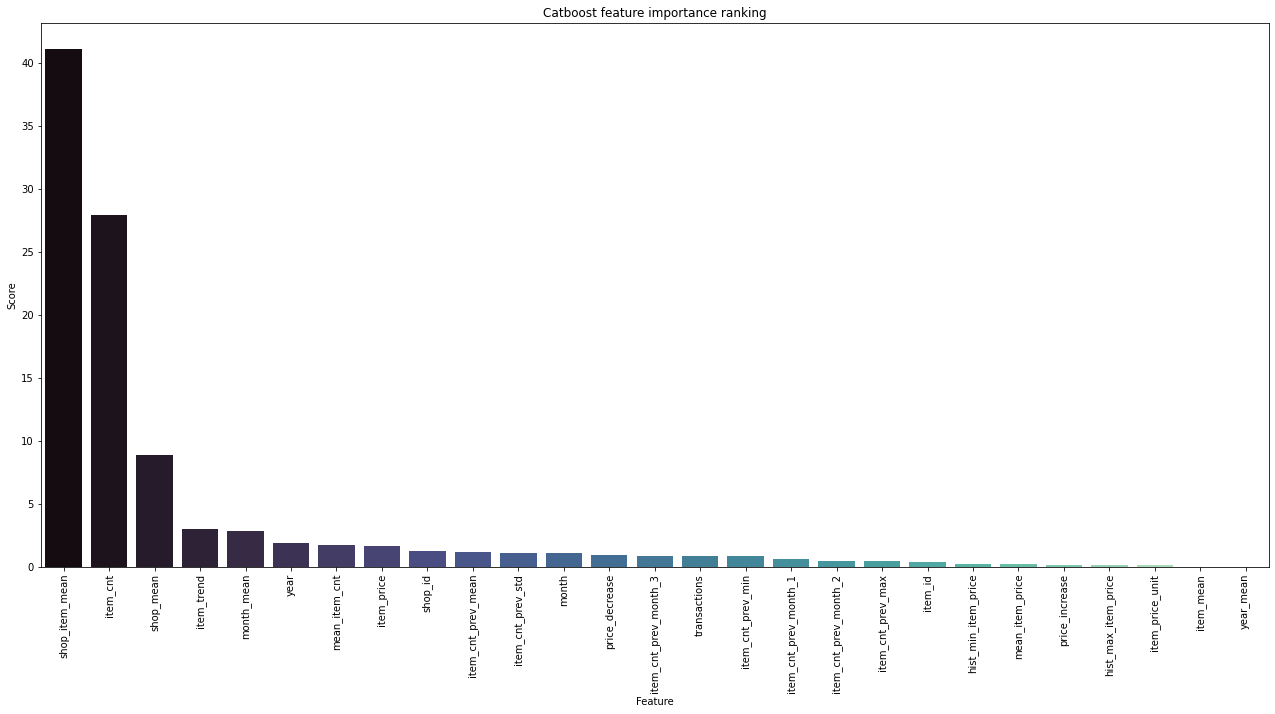

In [60]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.barplot(x="Feature", y="Score", data=feature_scores, ax=ax, palette='mako').set_title('Catboost feature importance ranking')
ax.tick_params(axis='x', rotation=90)

In [61]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, catboost_val_pred)))

Train rmse: 2.3308406837891926
Validation rmse: 3.256369698467858


In [62]:
X_train.shape

(2785100, 27)

In [64]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'item_cnt_prev_month_1', 'item_cnt_prev_month_2',
       'item_cnt_prev_month_3', 'item_cnt_prev_min', 'item_cnt_prev_max',
       'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend', 'shop_mean',
       'item_mean', 'shop_item_mean', 'year_mean', 'month_mean'],
      dtype='object')

In [63]:
X_train.query('shop_id == 2 and item_id == 7220')

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
61,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,3,0.000000,...,0.0,4.0,1.333333,2.309401,-1.333333,0.30206,0.839,0.56,0.355668,0.366486
111465,2,7220,2598.000000,1299.000000,2.0,1.0,2.0,2013,4,1299.000000,...,0.0,0.0,0.000000,0.000000,2.000000,0.30206,0.839,0.56,0.355668,0.346325
222869,2,7220,1299.000000,1299.000000,1.0,1.0,1.0,2013,5,1299.000000,...,0.0,2.0,0.666667,1.154701,0.333333,0.30206,0.839,0.56,0.355668,0.332511
334273,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,6,0.000000,...,0.0,2.0,1.000000,1.000000,-1.000000,0.30206,0.839,0.56,0.355668,0.382854
445677,2,7220,1299.000000,1299.000000,1.0,1.0,1.0,2013,7,1299.000000,...,0.0,2.0,1.000000,1.000000,0.000000,0.30206,0.839,0.56,0.355668,0.414280
557081,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,8,0.000000,...,0.0,1.0,0.666667,0.577350,-0.666667,0.30206,0.839,0.56,0.355668,0.417723
668485,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,9,0.000000,...,0.0,1.0,0.333333,0.577350,-0.333333,0.30206,0.839,0.56,0.355668,0.510776
779889,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,10,0.000000,...,0.0,1.0,0.333333,0.577350,-0.333333,0.30206,0.839,0.56,0.355668,0.773159
891293,2,7220,2598.000000,1299.000000,2.0,1.0,2.0,2013,11,1299.000000,...,0.0,0.0,0.000000,0.000000,2.000000,0.30206,0.839,0.56,0.355668,0.491594
1002697,2,7220,0.000000,0.000000,0.0,0.0,0.0,2014,0,0.000000,...,0.0,2.0,0.666667,1.154701,-0.666667,0.30206,0.839,0.56,0.490674,0.437332


In [66]:
monthly_sales.query('shop_id == 2 and item_id == 7220')

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,price_increase,price_decrease,item_cnt_prev_month_1,item_cnt_prev_month_2,item_cnt_prev_month_3,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend
61,0,2,7220,7995.399902,1998.849976,4.0,1.0,4.0,2013,0,...,7995.399902,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.000000
111465,1,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,1,...,0.000000,7995.399902,4.0,0.0,0.0,0.0,4.0,1.333333,2.309401,-1.333333
222869,2,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,2,...,0.000000,7995.399902,0.0,4.0,0.0,0.0,4.0,1.333333,2.309401,-1.333333
334273,3,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,3,...,0.000000,7995.399902,0.0,0.0,4.0,0.0,4.0,1.333333,2.309401,-1.333333
445677,4,2,7220,2598.000000,1299.000000,2.0,1.0,2.0,2013,4,...,2598.000000,5397.399902,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.000000
557081,5,2,7220,1299.000000,1299.000000,1.0,1.0,1.0,2013,5,...,1299.000000,6696.399902,2.0,0.0,0.0,0.0,2.0,0.666667,1.154701,0.333333
668485,6,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,6,...,0.000000,7995.399902,1.0,2.0,0.0,0.0,2.0,1.000000,1.000000,-1.000000
779889,7,2,7220,1299.000000,1299.000000,1.0,1.0,1.0,2013,7,...,1299.000000,6696.399902,0.0,1.0,2.0,0.0,2.0,1.000000,1.000000,0.000000
891293,8,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,8,...,0.000000,7995.399902,1.0,0.0,1.0,0.0,1.0,0.666667,0.577350,-0.666667
1002697,9,2,7220,0.000000,0.000000,0.0,0.0,0.0,2013,9,...,0.000000,7995.399902,0.0,1.0,0.0,0.0,1.0,0.333333,0.577350,-0.333333


Now we aggregate the data by adding up all the daily item counts over each month.

## Submission

We are now ready to submit our predictions. To avoid repeating the training with the whole dataset, we will abuse the data and use the linear regression coefficients for the first 33 months instead of the first 34.

In [220]:
first_agg_all_time['pred_34'] = first_agg_all_time['lr_b'] + first_agg_all_time['lr_m'] * 34
first_agg_all_time['pred_34'] = first_agg_all_time['pred_34'].clip(lower=0)

first_agg_all_time.head()

,shop_id,item_id,lr_b,lr_m,pred_33,pred_34
0,0,30,3.426025,-0.155414,0.0,0.0
1,0,31,1.215686,-0.055147,0.0,0.0
2,0,32,1.800357,-0.082219,0.0,0.0
3,0,33,0.679144,-0.031083,0.0,0.0
4,0,35,1.663102,-0.075535,0.0,0.0


We finally generate the csv file ready for submission.

In [221]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test_data, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)
    print("Submission successfully saved!")

In [222]:
generate_submission_file(first_agg_all_time, 'pred_34')

Submission successfully saved!
